### Load dependencies and helper functions

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
        
        
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [60]:
data = pd.read_csv("./data/instagram_processed.csv")


In [61]:
data.head()

,Unnamed: 0,caption,comments_count,id,ig_id,is_comment_enabled,is_shared_to_feed,like_count,media_product_type,media_type,permalink,shortcode,thumbnail_url,timestamp,username,reach,media_url,caption_cleaned
0,0,PQTEdeAyuda🚨¡Solidaridad en el oeste! Nos dimo...,1,17931058535370710,2943277675520514363,True,True,189,REELS,VIDEO,https://www.instagram.com/reel/CjYn3OkvNk7/,CjYn3OkvNk7,https://scontent.cdninstagram.com/v/t51.29350-...,2022-10-06T19:57:48+0000,plateapr,12209,NaN,PQTEdeAyuda ¡Solidaridad en el oeste! Nos dimo...
1,1,"¡Así es el boricua, en tiempos de crisis siemp...",5,17885652821667356,2942641641286289377,True,NaN,180,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjWXPtiJEfh/,CjWXPtiJEfh,NaN,2022-10-05T22:50:44+0000,plateapr,21547,https://scontent.cdninstagram.com/v/t51.2885-1...,"¡Así es el boricua, en tiempos de crisis siemp..."
2,2,PQTEdeAyuda 🚨 Nos fuimos el sábado junto a @pa...,3,17955116098987978,2941866596209322305,True,True,395,REELS,VIDEO,https://www.instagram.com/reel/CjTnBUjpOlB/,CjTnBUjpOlB,https://scontent.cdninstagram.com/v/t51.29350-...,2022-10-04T21:13:47+0000,plateapr,20479,NaN,PQTEdeAyuda Nos fuimos el sábado junto a @pa...
3,3,Continuemos dando la mano a quien más lo neces...,6,18306135466068527,2940248175567822591,True,NaN,199,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjN3CM4Nd7_/,CjN3CM4Nd7_,NaN,2022-10-02T15:35:20+0000,plateapr,14639,https://scontent.cdninstagram.com/v/t51.2885-1...,Continuemos dando la mano a quien más lo neces...
4,4,🚨 Atención residentes del oeste 🚨¿No te ha lle...,7,17948386553212739,2938229812469112677,True,NaN,750,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjGsHJwrx9l/,CjGsHJwrx9l,NaN,2022-09-29T20:45:10+0000,plateapr,33792,https://scontent.cdninstagram.com/v/t51.29350-...,Atención residentes del oeste ¿No te ha llega...


In [62]:
data.shape

(525, 18)

In [63]:
texts = data.caption_cleaned

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [102]:
# Words that are widely used and are not meaninful for topics
tags = ['parking', 'platea', 'plateapr', 'puertorico', 'puerto', 'rico', 'link', 'bio', 'pa', 'commentarios', 'apoyalolocal', 'plateasanjuan']

In [103]:
# Stop Words in spanish from: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# In addition to those we added the stop words for english since we do have some spanglish on the blogs

stop_words = []

with open("./data/stop_words.txt", "r") as file:
    stop_words = file.readlines()
stop_words = [s.strip().lower() for s in stop_words]
stop_words = stop_words + tags
stop_words[len(stop_words)-10: len(stop_words)-1]

['plateapr',
 'puertorico',
 'puerto',
 'rico',
 'link',
 'bio',
 'pa',
 'commentarios',
 'apoyalolocal']

In [104]:
#define our vectorizer class


# We also tried the Tfid vectorizer but the results on the CountVectorizer seemed better.
# tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))


In [105]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [106]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)

Shape = (525, 3958)


In [107]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
pqtedeayuda,2929
solidaridad,3490
oeste,2401
dimos,1185
vuelta,3895
germán,1650
brigadasolidariadeloeste,471
ofreciendo,2416
centro,640
acopio,120


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [108]:
n_components = 5
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [109]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

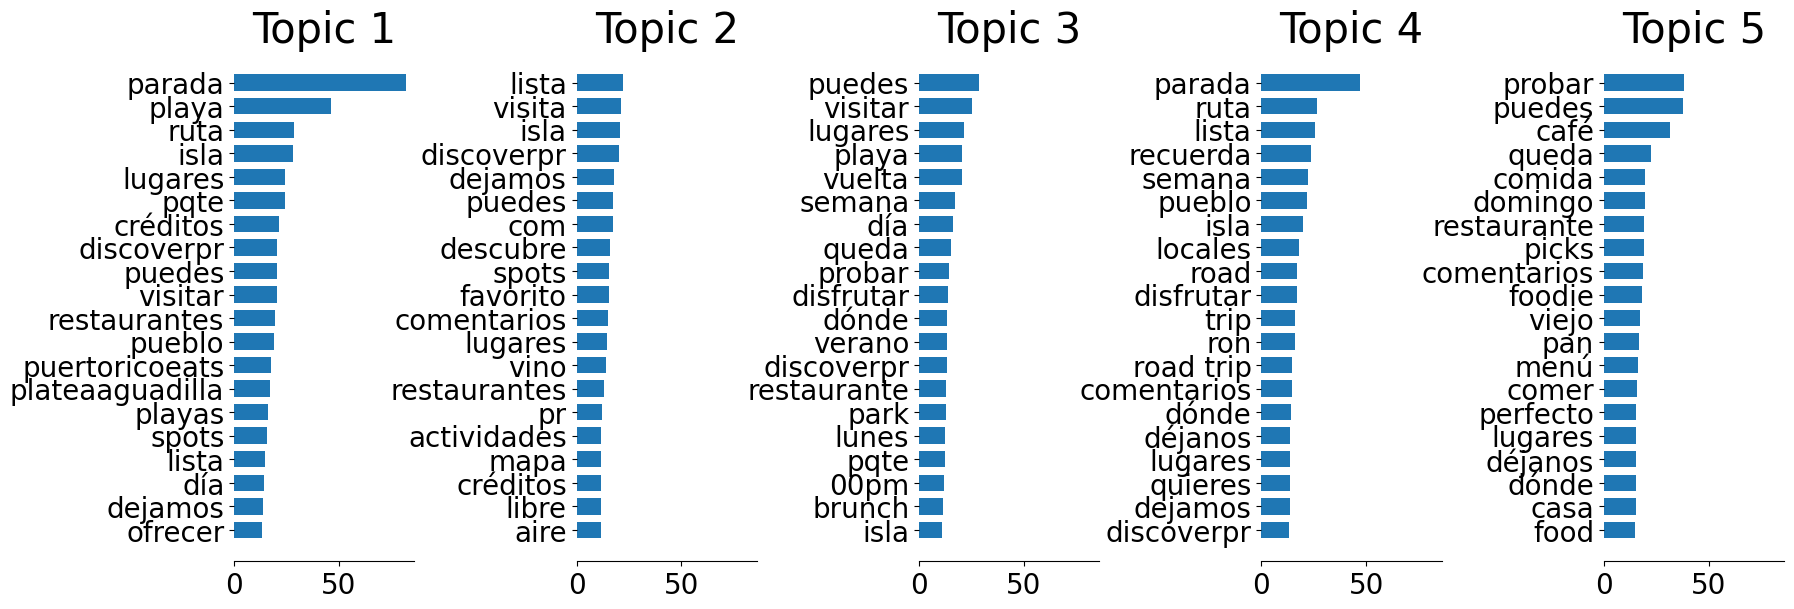

In [110]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "")

In [111]:
len(tf_feature_names)

3958

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [112]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

In [113]:
sample_idx = np.random.choice(len(texts))
sample_idx

467

In [114]:
print(texts[sample_idx])

¿Estás buscando qué hacer este wiken? We got you   ApoyaLoLocal


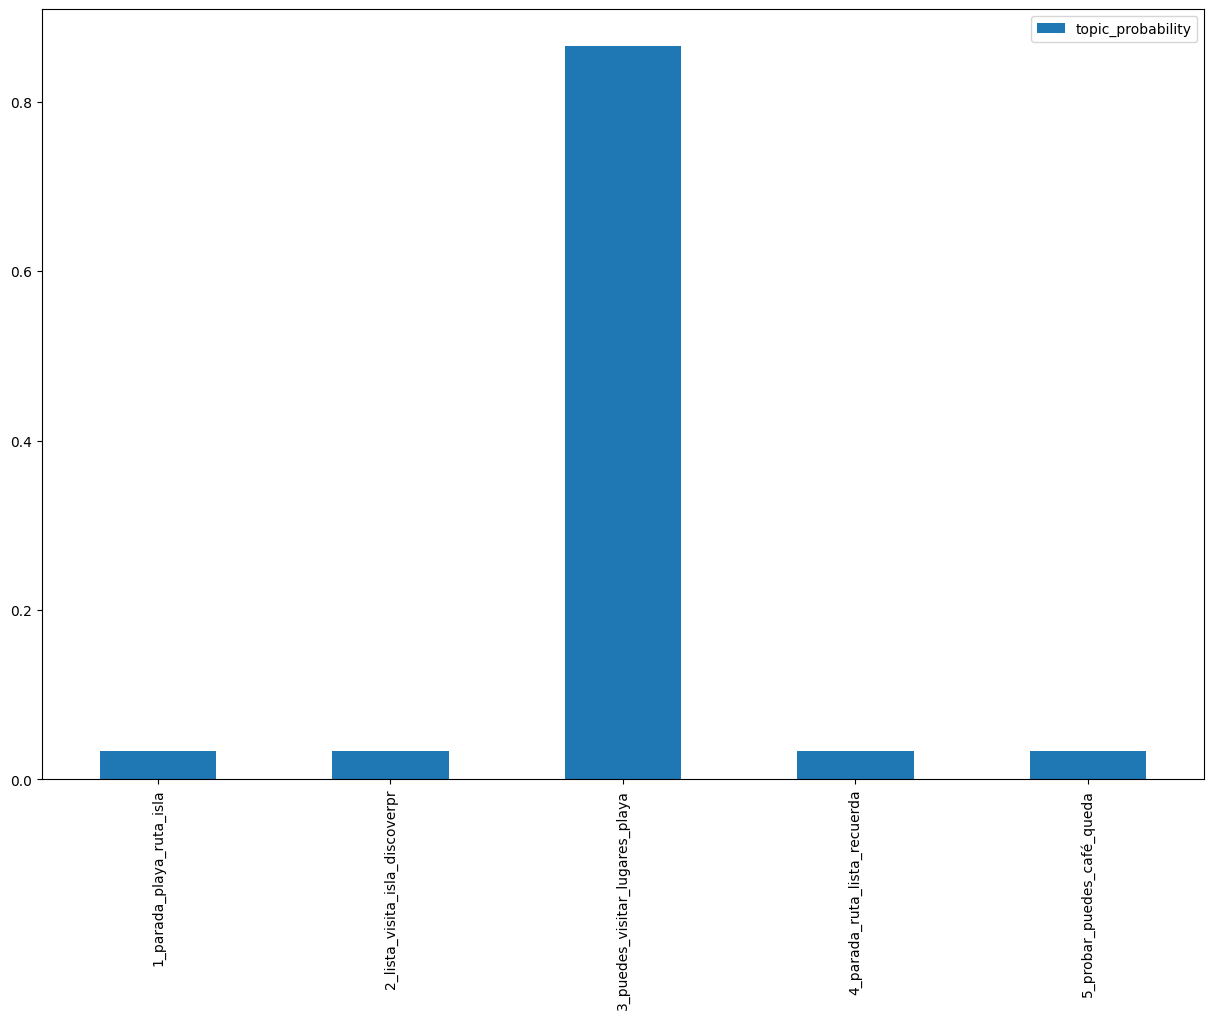

In [115]:
pd.DataFrame(index= topic_names, data= clusters[sample_idx], columns = ["topic_probability"]).plot.bar(figsize = (15,10), rot=90)
plt.show()

In [116]:
titles = texts
topics = []
for i in range(len(data)):
    probs = pd.DataFrame(index= topic_names, data= clusters[i], columns = ["topic_probability"])
    # print(titles[i], ": ",probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0])
    topics.append(probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0]) 


In [117]:
data['topic']=topics  
data.head()


,Unnamed: 0,caption,comments_count,id,ig_id,is_comment_enabled,is_shared_to_feed,like_count,media_product_type,media_type,permalink,shortcode,thumbnail_url,timestamp,username,reach,media_url,caption_cleaned,topic
0,0,PQTEdeAyuda🚨¡Solidaridad en el oeste! Nos dimo...,1,17931058535370710,2943277675520514363,True,True,189,REELS,VIDEO,https://www.instagram.com/reel/CjYn3OkvNk7/,CjYn3OkvNk7,https://scontent.cdninstagram.com/v/t51.29350-...,2022-10-06T19:57:48+0000,plateapr,12209,NaN,PQTEdeAyuda ¡Solidaridad en el oeste! Nos dimo...,3_puedes_visitar_lugares_playa
1,1,"¡Así es el boricua, en tiempos de crisis siemp...",5,17885652821667356,2942641641286289377,True,NaN,180,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjWXPtiJEfh/,CjWXPtiJEfh,NaN,2022-10-05T22:50:44+0000,plateapr,21547,https://scontent.cdninstagram.com/v/t51.2885-1...,"¡Así es el boricua, en tiempos de crisis siemp...",2_lista_visita_isla_discoverpr
2,2,PQTEdeAyuda 🚨 Nos fuimos el sábado junto a @pa...,3,17955116098987978,2941866596209322305,True,True,395,REELS,VIDEO,https://www.instagram.com/reel/CjTnBUjpOlB/,CjTnBUjpOlB,https://scontent.cdninstagram.com/v/t51.29350-...,2022-10-04T21:13:47+0000,plateapr,20479,NaN,PQTEdeAyuda Nos fuimos el sábado junto a @pa...,2_lista_visita_isla_discoverpr
3,3,Continuemos dando la mano a quien más lo neces...,6,18306135466068527,2940248175567822591,True,NaN,199,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjN3CM4Nd7_/,CjN3CM4Nd7_,NaN,2022-10-02T15:35:20+0000,plateapr,14639,https://scontent.cdninstagram.com/v/t51.2885-1...,Continuemos dando la mano a quien más lo neces...,2_lista_visita_isla_discoverpr
4,4,🚨 Atención residentes del oeste 🚨¿No te ha lle...,7,17948386553212739,2938229812469112677,True,NaN,750,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CjGsHJwrx9l/,CjGsHJwrx9l,NaN,2022-09-29T20:45:10+0000,plateapr,33792,https://scontent.cdninstagram.com/v/t51.29350-...,Atención residentes del oeste ¿No te ha llega...,1_parada_playa_ruta_isla


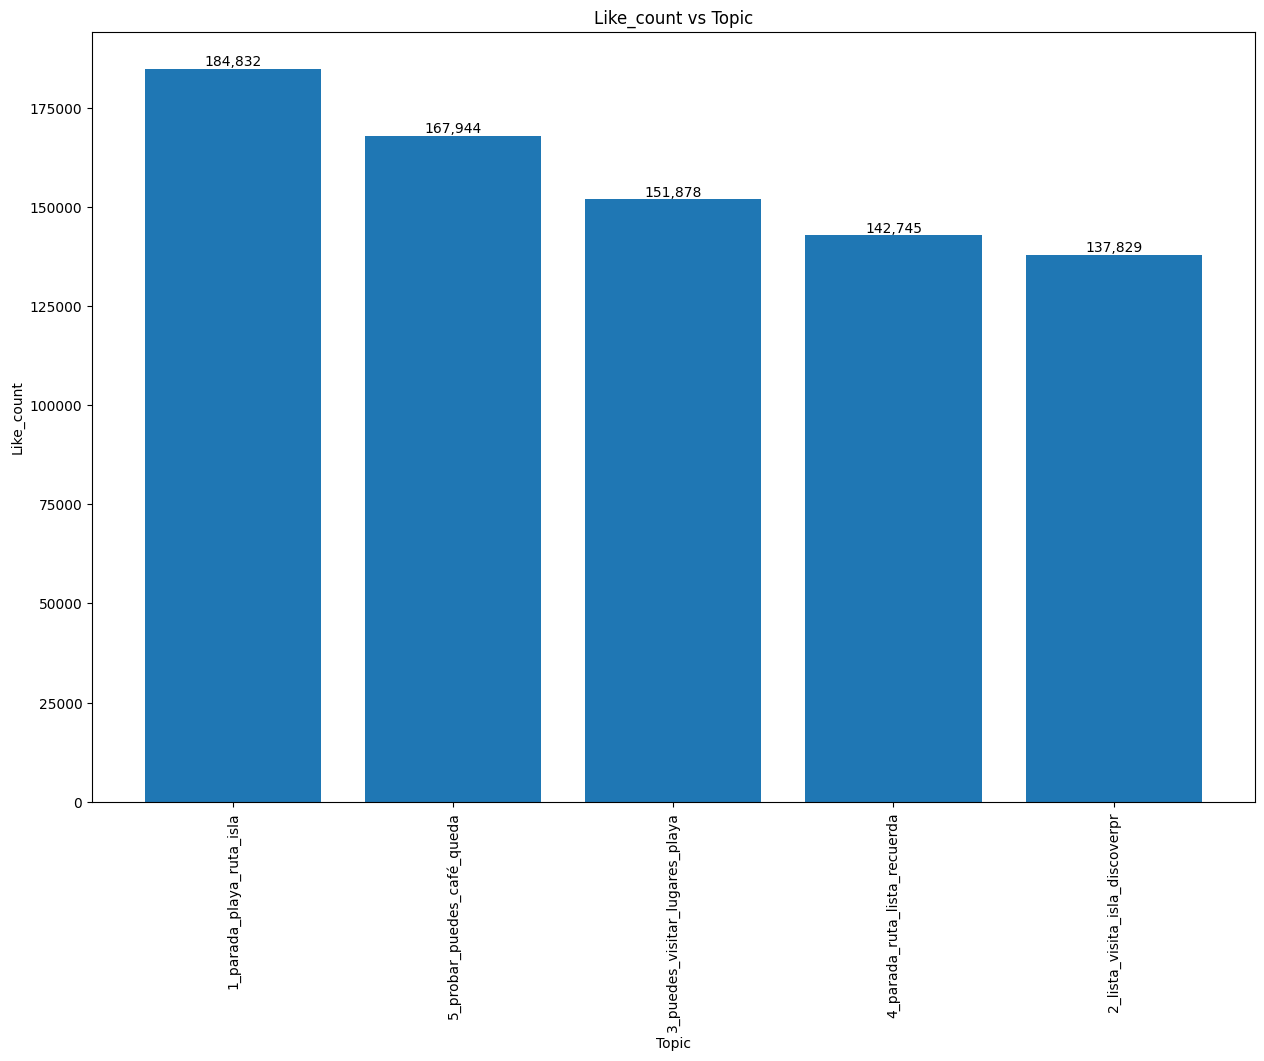

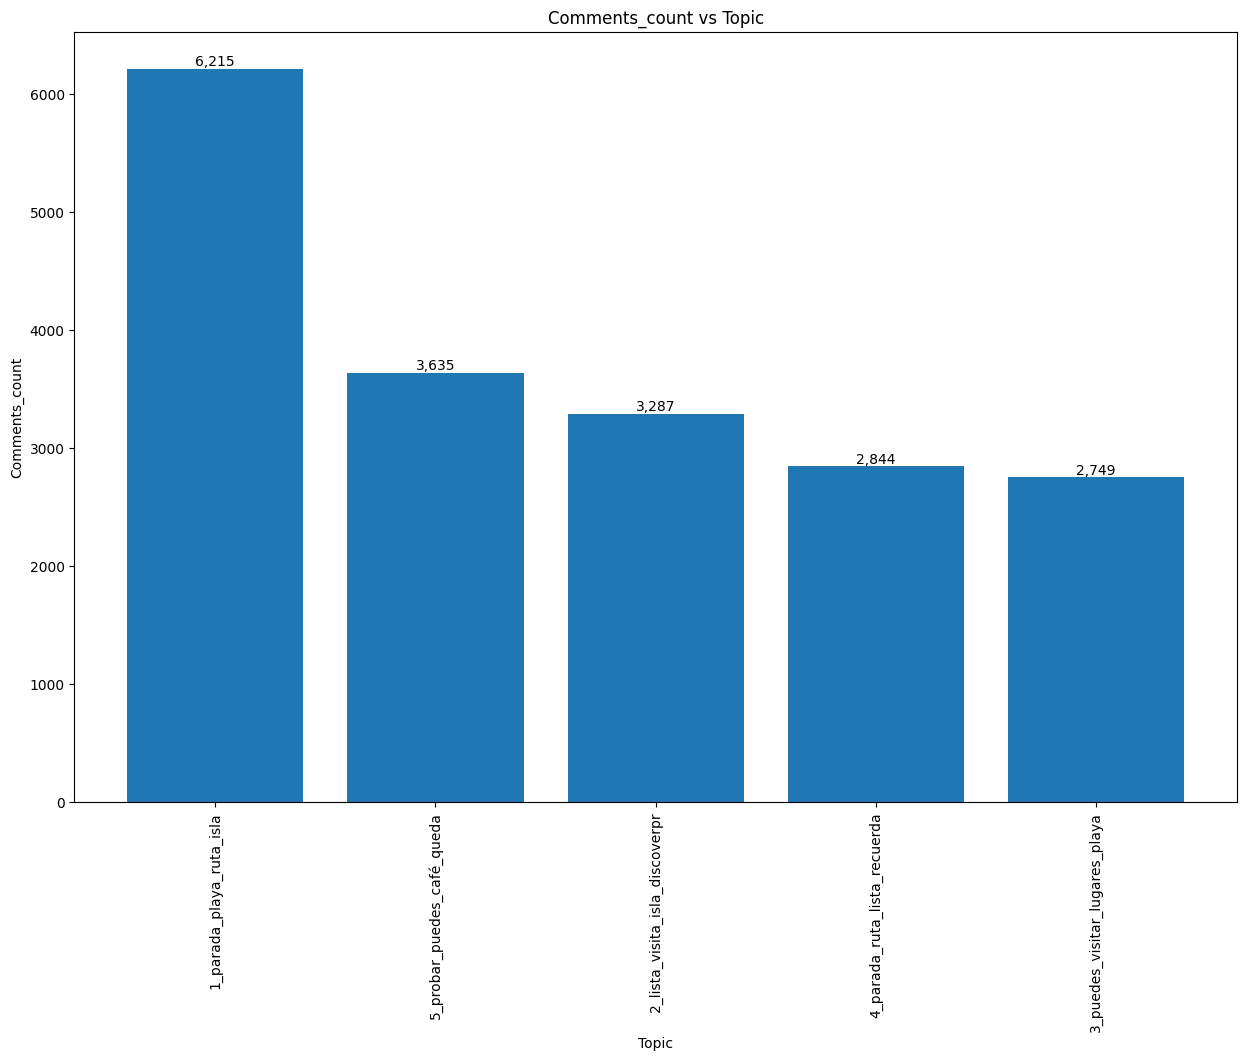

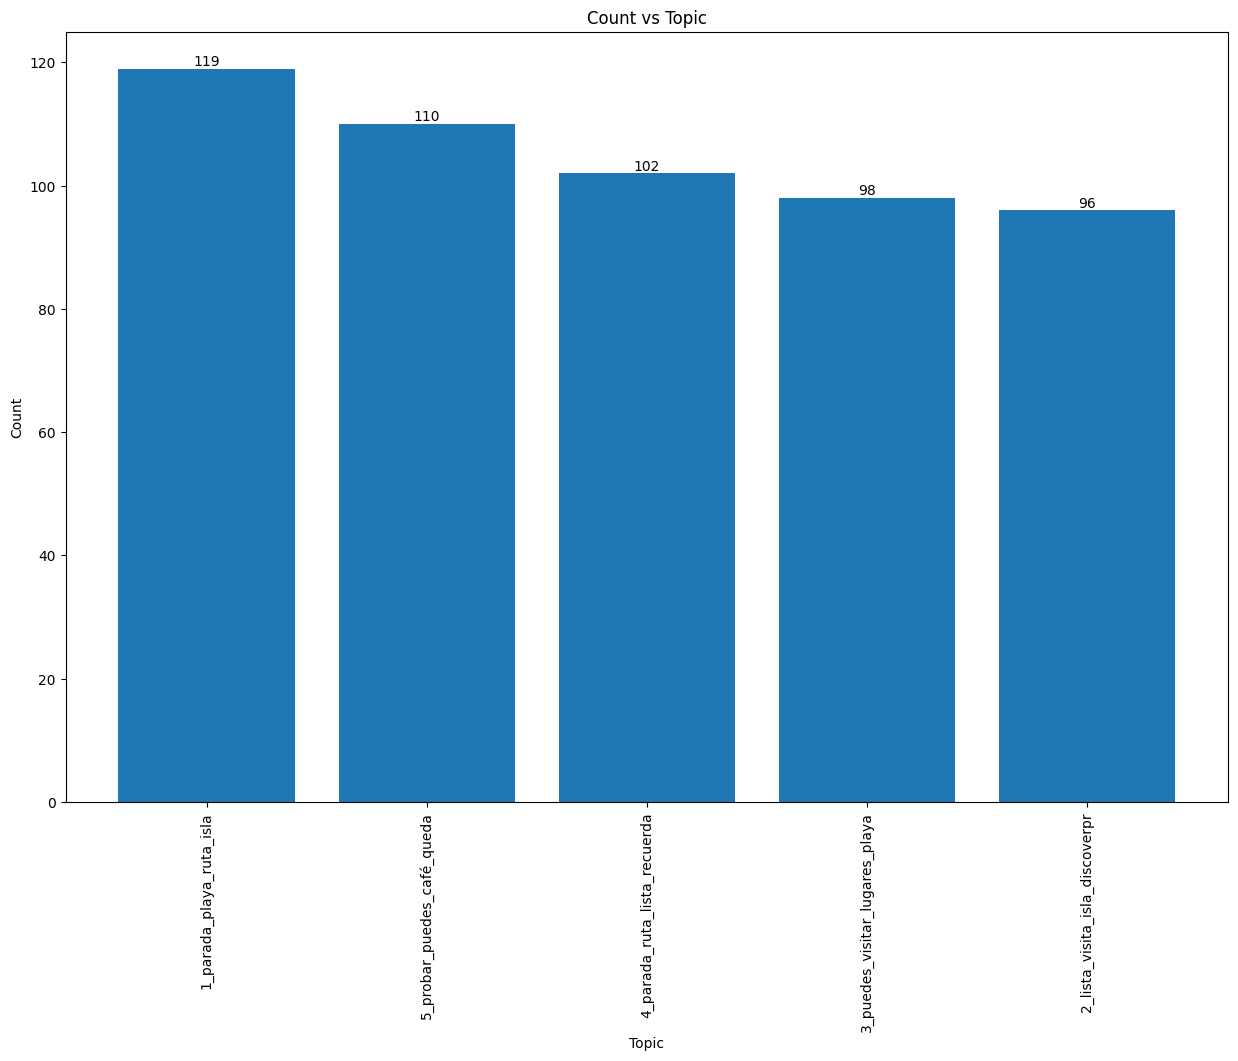

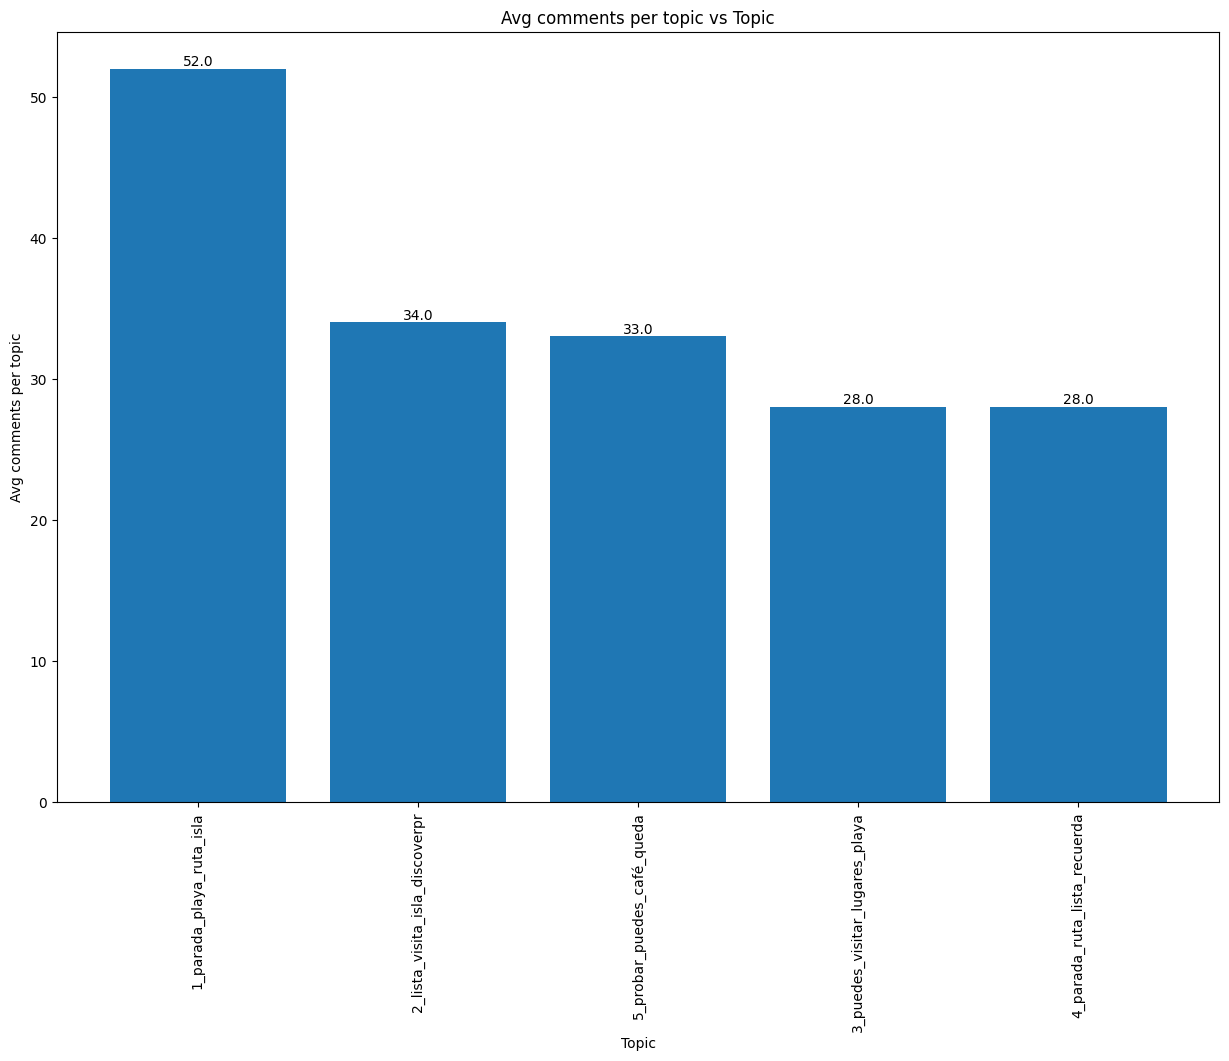

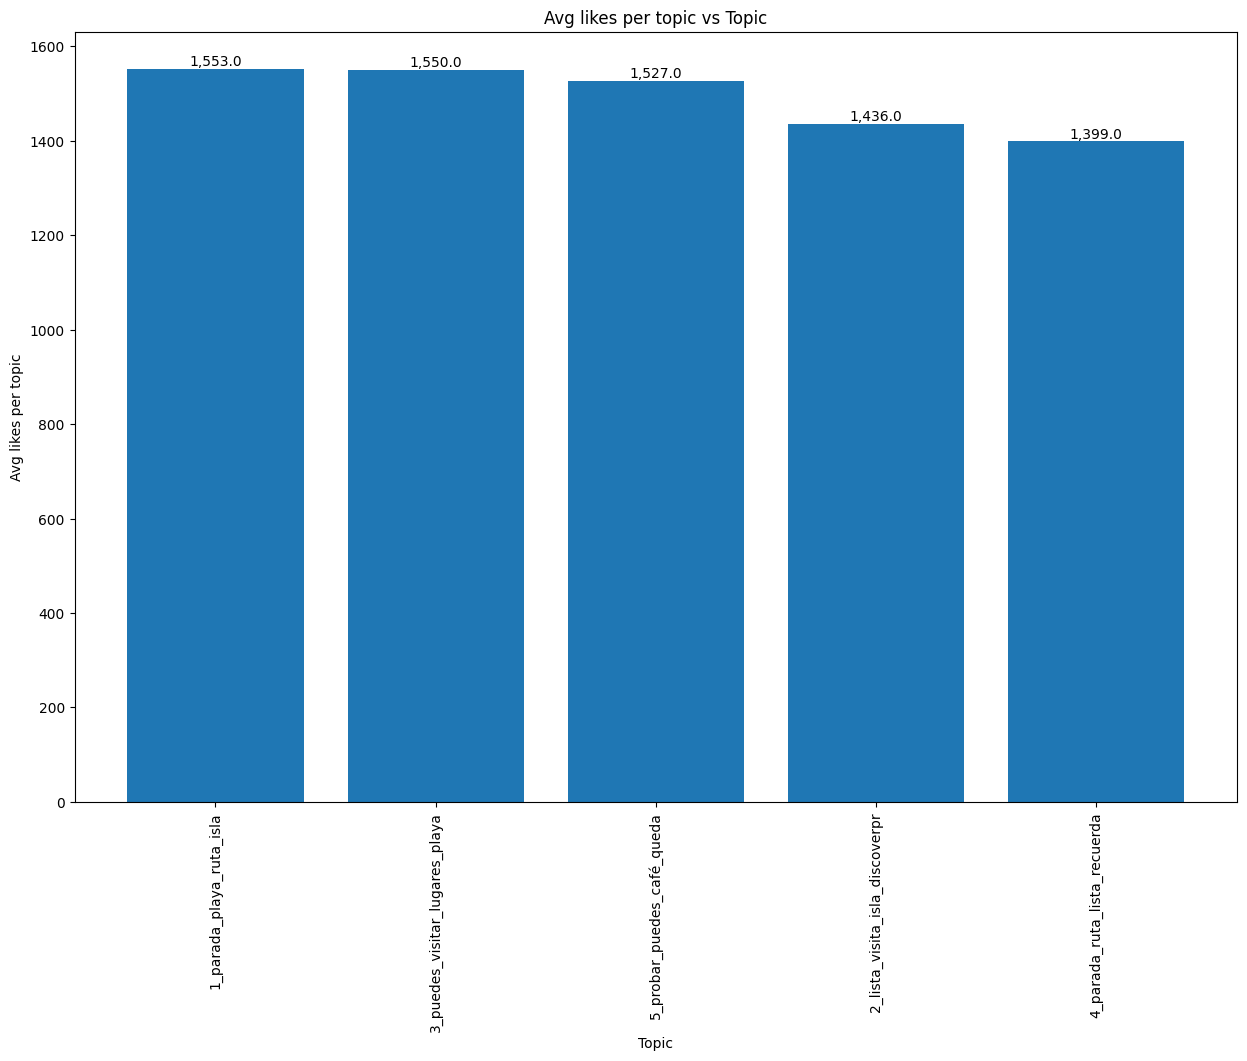

In [118]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})


by_topic = data.groupby('topic').agg({'like_count': 'sum', 'comments_count':'sum'}).reset_index()
by_topic = pd.merge(by_topic, counts, how='inner', left_on = 'topic', right_on = 'topic')

by_topic['AVG Comments per topic'] = round(by_topic['comments_count']/by_topic['count'],0)

by_topic['AVG Likes per topic'] = round(by_topic['like_count']/by_topic['count'],0)

y_values = [c for c in by_topic.columns if c != 'topic']
for c in y_values:
    sorted_df = by_topic.sort_values(by=[c], ascending=False)
    figure = plt.figure('myfigureid', figsize = (15,10))
    axis = figure.add_subplot(1,1,1)
    axis.bar(sorted_df['topic'], sorted_df[c])
    
    rects = axis.patches

    # Make some labels.

    for rect, label in zip(rects, sorted_df[c]):
        height = rect.get_height()
        axis.text(
            rect.get_x() + rect.get_width() / 2, height, "{:,}".format(label), ha="center", va="bottom"
        )

    axis.set_ylabel(c.capitalize())
    axis.set_xlabel('topic'.capitalize())
    axis.set_title(f"{c.capitalize()} vs Topic")
    plt.xticks(rotation = 90)
    plt.show()

In [119]:
# See the titles on each topic to get an idea

for topic in counts['topic'].values:
    print(topic)
    for title in data[data.topic ==topic]['caption_cleaned'].values:
        print(f'\t\t{title}')
    print('\n')

1_parada_playa_ruta_isla
		Atención residentes del oeste  ¿No te ha llegado la luz o no tienes señal? Aquí te compartimos 6 restaurantes con Wifi donde también puedes cargar tu teléfono.   @cocinamereketengue   @thecoffeespotpr   @beerloteca   @clarascoffeepr   @5starfrappegourmet   @aguadillarooftop.arte Si conoces de algún otro spot, por favor compártelo en los comentarios.   Platea PlateaPR PlateaAguadilla PlateaMayaguez PlateaAguada HuracanFiona ApoyaLoLocal IslaDelEncanto PuertoRico
		Estos ángeles guardianes de las mascotas, como @SaveASato y @petfriendly_pr, necesitan una mano en su encomienda de salvar a los animalitos que también sufren las consecuencias del huracán Fiona.   ¡Solo nosotros podemos ayudarlos!       ¿Cuáles son las entidades?   @Santuario.sasfapr Cabo Rojo   @RabitoKontento Hatillo   @ElFosterClub Todo PR   @FaroDeLosAnimales Humacao   @HuellitasDePuertoRico Jayuya   @PetFriendly_PR Todo PR   @saveasatopuertorico San Juan ¿Qué donar? Agua, comida y artículos de 

# Lets take a look of instagram
